<a href="https://colab.research.google.com/github/Ssurf777/VAEforPointCloud/blob/main/VQVAE_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install POT

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 7.4 MB/s eta 0:00:00


In [ ]:
import requests
import os

def download_file(url, local_filename):
    """Downloads a file from a URL to a local file."""
    print(f"Downloading {url}...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            with open(local_filename, 'wb') as f:
                for chunk in r.iter_content(chunk_size=4096):  # Smaller chunk size
                    f.write(chunk)
        print(f"{local_filename} downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {local_filename}: {e}")

# URLs for downloading
urls = {
    "utils.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/utils.py",
    "file_io.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/file_io.py",
    "point_cloud.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/point_cloud.py",
    "sampling.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/sampling.py",
    "ChamferDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/ChamferDis.py",
    "EarthMoversDis.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/EarthMoversDis.py",
    "train.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/train.py",
    "visualize_loss.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/visualize_loss.py",
    "Dataloader.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/Dataloader.py",
    "vqvae_v2_models.py": "https://raw.githubusercontent.com/Ssurf777/VAEforPointCloud/main/lib/vqvae_v2_models.py",
}

# Download each file
for local_filename, url in urls.items():
    download_file(url, local_filename)



utils.py downloaded successfully.
file_io.py downloaded successfully.
point_cloud.py downloaded successfully.
sampling.py downloaded successfully.
ChamferDis.py downloaded successfully.
EarthMoversDis.py downloaded successfully.
train.py downloaded successfully.
visualize_loss.py downloaded successfully.
Dataloader.py downloaded successfully.
vqvae_v2_models.py downloaded successfully.


In [ ]:

# Import downloaded modules
import utils
import file_io
import point_cloud
import sampling
import ChamferDis
import EarthMoversDis
import train
import Dataloader
import visualize_loss
import vqvae_v2_models
from utils import get_available_memory
from file_io import read_off
from point_cloud import pcshow
from sampling import PointSampler
from ChamferDis import chamfer_distance
from EarthMoversDis import emd_distance
from train import train
from visualize_loss import visualize_loss
from Dataloader import prepare_data_for_ISAB
from vqvae_v2_models import VQVAE

available_memory_gb = get_available_memory()
print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 10.96 GB


In [ ]:
import torch
import torch.optim as optim
import numpy as np



device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_points =5000
# データ準備
file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1, 10)]
data_loader = prepare_data_for_ISAB(file_names, num_points=num_points, device=device)
print(len(data_loader))

9


In [ ]:

# ---------------- Training Loop ----------------

# ハイパーパラメータ設定
epochs = 5000
interval = 100

# モデル、オプティマイザ、デバイスなどの設定（例）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_points = 5000
n_z = 3  # 潜在次元
#model = MoGVAE(num_points=5000, n_z=3, n_components=2).to(device)
model = VQVAE(n_dim=3, num_points=5000, embedding_dim=3, num_embeddings=32).to(device)

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/chair/VQVAE_v2_Np5000_MSE_0320.pth', map_location=device))

<All keys matched successfully>

In [ ]:
model

VQVAE(
  (encoder): Sequential(
    (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.001)
    (2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (3): LeakyReLU(negative_slope=0.001)
    (4): Conv1d(128, 3, kernel_size=(1,), stride=(1,))
    (5): AdaptiveMaxPool1d(output_size=1)
  )
  (quantizer): VectorQuantizer(
    (embedding): Embedding(32, 3)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(3, 128, kernel_size=(1,), stride=(1,))
    (1): LeakyReLU(negative_slope=0.001)
    (2): ConvTranspose1d(128, 64, kernel_size=(1,), stride=(1,))
    (3): LeakyReLU(negative_slope=0.001)
    (4): ConvTranspose1d(64, 15000, kernel_size=(1,), stride=(1,))
  )
)

In [ ]:
import numpy as np
import torch

z_list_final = []

model.eval()

with torch.no_grad():
    for i, data in enumerate(data_loader):
        if isinstance(data, (list, tuple)):
           inputs = data[0].to(device)
        else:
           inputs = data.to(device)

        inputs = inputs.permute(0, 2, 1)  # Conv1d 用に shape を変換

        _, _, z, _ = model(inputs)
        #x_recon, quantization_loss, z, self.embedding_dim
        z_np = z.squeeze().cpu().detach().numpy()  # (3,) の shape にする

        z_list_final.append(z_np)

z_list_final_np = np.stack(z_list_final, axis=0)  # (9, 3) になる
np.save('z_list_final.npy', z_list_final_np)


In [ ]:
z_list_final_np.shape

(9, 3)

In [ ]:
print(z_list_final_np) # z mu logvar

[[-8.75326917e-02 -9.85790044e-02  1.00268260e-01]
 [-2.60122389e-01 -1.92816764e-01 -6.86208457e-02]
 [-1.12415284e-01  1.01677049e-02 -2.28047252e-01]
 [ 2.62986720e-02 -3.97128537e-02 -4.72664833e-05]
 [ 1.26177222e-02  1.73307180e-01  8.11710432e-02]
 [-2.86406204e-02  1.20663494e-01 -6.25585616e-02]
 [ 2.96096988e-02  2.12347552e-01  2.82424763e-02]
 [-3.58612716e-01  2.91295201e-02 -8.19135457e-02]
 [ 1.67890824e-02  2.06710488e-01  1.11699559e-01]]


# 再構成形状の可視化

torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])
torch.Size([1, 5000, 3])


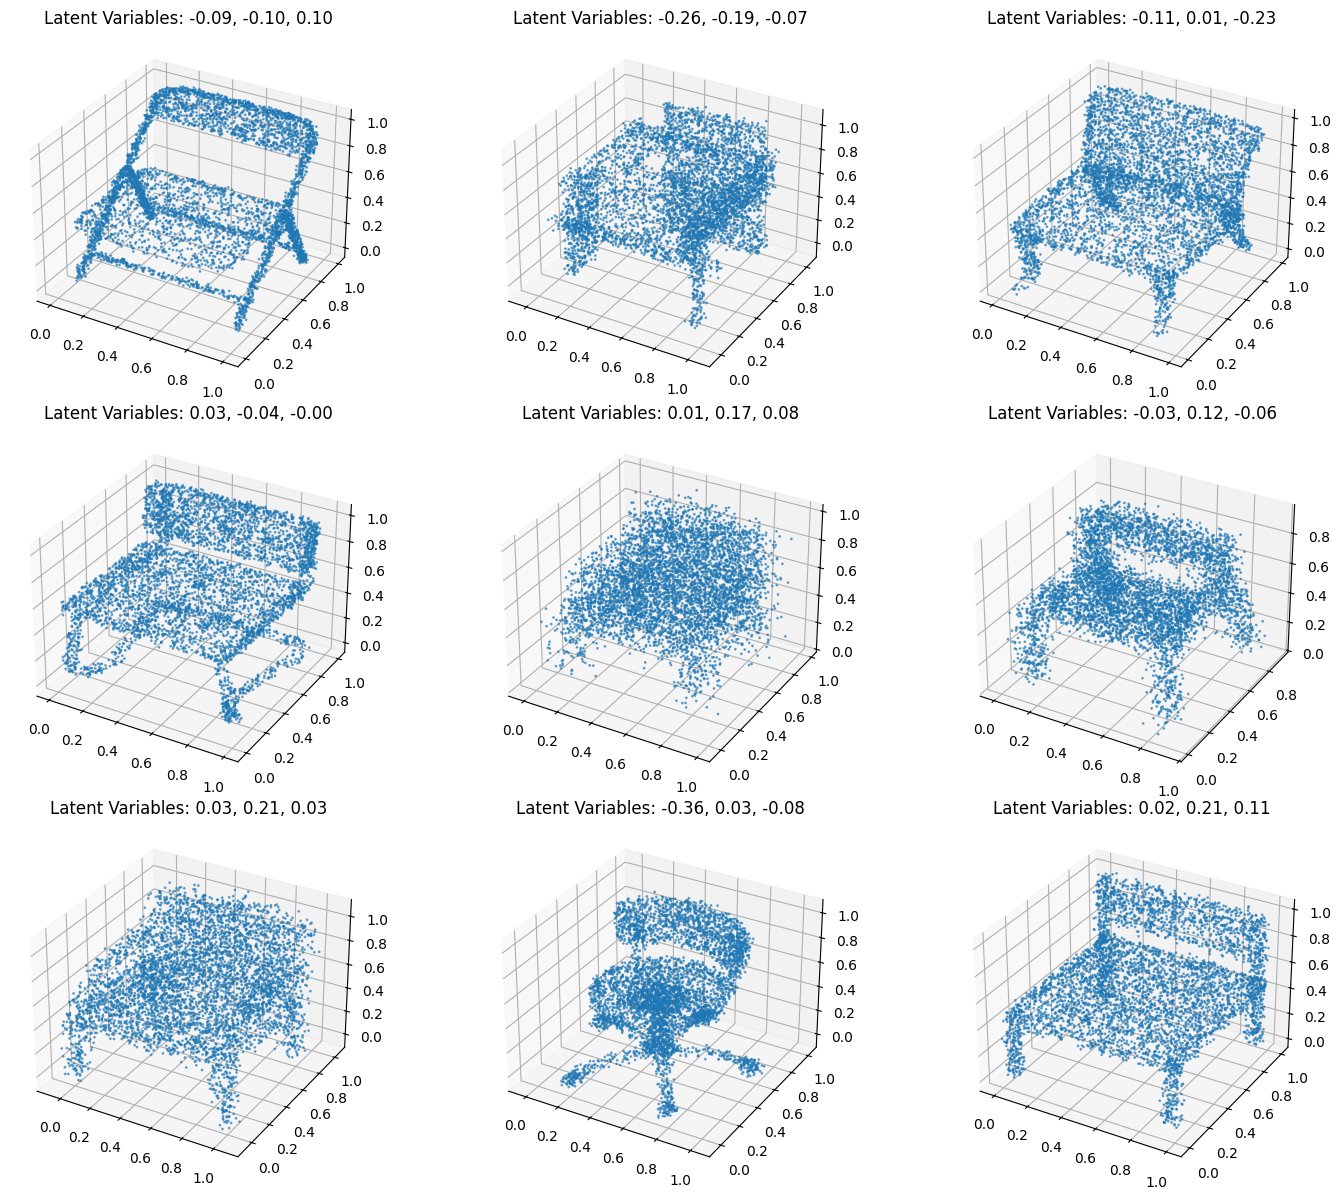

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# z_list_final.npy を読み込んで z_list に変換
z_array = np.load("z_list_final.npy")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
z_list = [torch.tensor(z_array[i], dtype=torch.float32).to(device) for i in range(z_array.shape[0])]

# 可視化用設定
num_points = 5000
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), subplot_kw={'projection': '3d'})
axes = axes.flatten()

# 再構成と可視化
for index, z in enumerate(z_list):
    if index >= len(axes):
        break  # 9つのプロットで終了

    # 再構築 (z を 1バッチの形に変換して decode)
    z_input = z.unsqueeze(0)  # shape: (1, 3)
    recon_batch = model.decode(z_input)

    #recon_batch = model.decode(z)  # z をバッチの形状に変換
    print(recon_batch.shape)

    # CPU上で detach して numpy に変換
    # デコード結果 recon_batch: (1, num_points, 3)
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得
    reconst_x = reconst_np[:, 0]
    reconst_y = reconst_np[:, 1]
    reconst_z = reconst_np[:, 2]

    # プロット
    axes[index].scatter(reconst_x, reconst_y, reconst_z, s=1, alpha=0.6)

    # 潜在変数の値をフラット化してタイトルに表示
    z_flat = z.view(-1).tolist()  # 1次元化
    z_str = ", ".join([f"{value:.2f}" for value in z_flat])
    axes[index].set_title(f"Latent Variables: {z_str}")

# 最後にプロットを表示
plt.tight_layout()
plt.show()


# Latent Space変化アニメ

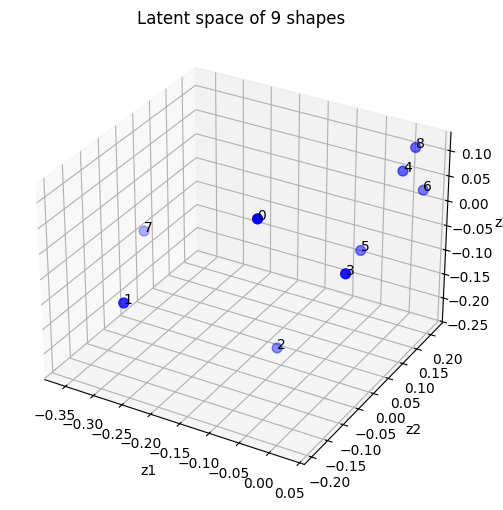

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

z_array = np.load('z_list_final.npy')  # shape (9, 3)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_array[:, 0], z_array[:, 1], z_array[:, 2], c='blue', s=50)

for i, (x, y, z) in enumerate(z_array):
    ax.text(x, y, z, f'{i}', color='black', fontsize=10)

ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_zlabel('z3')
plt.title('Latent space of 9 shapes')
plt.show()


# Latent Space ±0.1 Variations for All Designs

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from mpl_toolkits.mplot3d import Axes3D

# データ読み込み
z_array = np.load('z_list_final.npy')  # (9, 3)

# 設定
deltas = [-0.1, 0.0, 0.1]
axis_labels = ['z1', 'z2', 'z3']
num_designs = len(z_array)

# 潜在空間の軸範囲
z1_min, z1_max = np.min(z_array[:, 0]) - 1, np.max(z_array[:, 0]) + 1
z2_min, z2_max = np.min(z_array[:, 1]) - 1, np.max(z_array[:, 1]) + 1
z3_min, z3_max = np.min(z_array[:, 2]) - 1, np.max(z_array[:, 2]) + 1

# 検証対象のすべての(z軸, delta)ペアを準備
frames_list = []
for idx in range(num_designs):
    for axis in range(3):  # z1, z2, z3
        for delta in deltas:
            z_base = z_array[idx].copy()
            z_mod = z_base.copy()
            z_mod[axis] += delta
            frames_list.append((idx, axis, delta, z_mod))

# Figure 初期化
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')  # 潜在空間
ax2 = fig.add_subplot(122, projection='3d')  # 再構成形状

# 更新関数
def update(frame_idx):
    ax1.cla()
    ax2.cla()

    idx, axis, delta, z_mod = frames_list[frame_idx]

    # --- ax1: 潜在空間 ---
    ax1.scatter(z_array[:, 0], z_array[:, 1], z_array[:, 2], c='gray', s=30, alpha=0.5)
    ax1.scatter(z_mod[0], z_mod[1], z_mod[2], c='red', s=100)
    for i, (x, y, z) in enumerate(z_array):
        ax1.text(x, y, z, f'{i}', color='black', fontsize=8)

    ax1.set_title(f"Design {idx} / {axis_labels[axis]} change: {delta:+.2f}", fontsize=10, fontweight='bold')
    ax1.set_xlabel('z1')
    ax1.set_ylabel('z2')
    ax1.set_zlabel('z3')
    ax1.set_xlim([z1_min, z1_max])
    ax1.set_ylim([z2_min, z2_max])
    ax1.set_zlim([z3_min, z3_max])

    # --- ax2: 再構成形状 ---
    z_tensor = torch.tensor(z_mod, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        pointcloud = model.decode(z_tensor).squeeze(0).cpu().numpy()

    z_vals = pointcloud[:, 2]
    norm = plt.Normalize(z_vals.min(), z_vals.max())
    colors = plt.cm.viridis(norm(z_vals))

    ax2.scatter(
        pointcloud[:, 0],
        pointcloud[:, 1],
        pointcloud[:, 2],
        c=colors,
        s=2,
        alpha=0.85,
        edgecolors='none',
        depthshade=True
    )
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    ax2.set_zlim([0, 1])
    ax2.set_facecolor((1, 1, 1))
    ax2.grid(False)
    ax2.xaxis.pane.fill = False
    ax2.yaxis.pane.fill = False
    ax2.zaxis.pane.fill = False

    ax2.set_title(f"Reconstructed Shape", fontsize=10, fontweight='bold')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

# アニメーション作成
ani = FuncAnimation(fig, update, frames=len(frames_list), interval=500)
writer = PillowWriter(fps=2, metadata={'loop': 0})
ani.save("latent_variation_by_axis.gif", writer=writer)
plt.close()


# ALL Design Visual

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter

# 潜在ベクトル読み込み
z_array = np.load('z_list_final.npy')  # shape: (9, 3)
num_pairs = len(z_array) - 1  # z0→z1, z1→z2, ..., z7→z8

# 補間設定
frames_per_pair = 20  # 各ペアの補間ステップ数
num_frames = frames_per_pair * num_pairs

# 潜在空間の軸範囲
z1_min, z1_max = np.min(z_array[:, 0]) - 1, np.max(z_array[:, 0]) + 1
z2_min, z2_max = np.min(z_array[:, 1]) - 1, np.max(z_array[:, 1]) + 1
z3_min, z3_max = np.min(z_array[:, 2]) - 1, np.max(z_array[:, 2]) + 1

# Figure 初期化
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# 補間関数（連続ペア）
def interpolate(frame):
    pair_idx = frame // frames_per_pair
    t_idx = frame % frames_per_pair
    t = t_idx / frames_per_pair

    z_start = z_array[pair_idx]
    z_end = z_array[pair_idx + 1]

    z_interp = (1 - t) * z_start + t * z_end
    return z_interp, t, pair_idx

# 更新関数（フレームごと）
def update(frame):
    ax1.cla()
    ax2.cla()

    z_interp, t, pair_idx = interpolate(frame)

    # 潜在空間の描画
    ax1.scatter(z_array[:, 0], z_array[:, 1], z_array[:, 2], c='gray', s=30, alpha=0.5)
    for i in range(len(z_array) - 1):
        ax1.plot(
            [z_array[i][0], z_array[i+1][0]],
            [z_array[i][1], z_array[i+1][1]],
            [z_array[i][2], z_array[i+1][2]],
            c='blue', linestyle='--'
        )
    ax1.scatter(z_interp[0], z_interp[1], z_interp[2], c='red', s=100)

    for i, (x, y, z) in enumerate(z_array):
        ax1.text(x, y, z, f'{i}', color='black', fontsize=8)

    ax1.set_title(f"Latent Interpolation [{pair_idx}→{pair_idx+1}] t={t:.2f}", fontsize=10, fontweight='bold')
    ax1.set_xlabel('z1')
    ax1.set_ylabel('z2')
    ax1.set_zlabel('z3')
    ax1.set_xlim([z1_min, z1_max])
    ax1.set_ylim([z2_min, z2_max])
    ax1.set_zlim([z3_min, z3_max])

    # decode して点群再構成
    z_tensor = torch.tensor(z_interp, dtype=torch.float32).unsqueeze(0).to(device)
    with torch.no_grad():
        pointcloud = model.decode(z_tensor).squeeze(0).cpu().numpy()

    z_vals = pointcloud[:, 2]
    norm = plt.Normalize(z_vals.min(), z_vals.max())
    colors = plt.cm.viridis(norm(z_vals))

    ax2.scatter(
        pointcloud[:, 0],
        pointcloud[:, 1],
        pointcloud[:, 2],
        c=colors,
        s=3,
        alpha=0.85,
        edgecolors='none',
        depthshade=True
    )

    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    ax2.set_zlim([0, 1])
    ax2.set_facecolor((1, 1, 1.0))
    ax2.grid(False)
    ax2.xaxis.pane.fill = False
    ax2.yaxis.pane.fill = False
    ax2.zaxis.pane.fill = False

    ax2.set_title(f"Interpolated Shape t = {t:.2f}", fontsize=10, fontweight='bold')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

# アニメーション生成・保存
ani = FuncAnimation(fig, update, frames=num_frames, interval=100)
writer = PillowWriter(fps=10, metadata={'loop': 0})
ani.save("interpolation_all_shapes_VQVAE.gif", writer=writer)
plt.close()


# 再構成誤差チェック using CD

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
reconstructed_point_cloud=[]
# Chamfer Distanceの計算
chamfer_distances = []
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = model.decode(z_list[i])
    # CPU上で detach して numpy に変換
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得し、Tensor に変換
    reconst_x = torch.from_numpy(reconst_np[:, 0])
    reconst_y = torch.from_numpy(reconst_np[:, 1])
    reconst_z = torch.from_numpy(reconst_np[:, 2])

    # Tensor を stack して reconstructed_point_cloud を作成
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)


    # 元の点群の形状を整える
    original_point_cloud = x.reshape(1, num_points, 3).to(device)

    # カスタム関数でChamfer Distanceを計算
    loss_cd = chamfer_distance(original_point_cloud, reconstructed_point_cloud)
    chamfer_distances.append(loss_cd.item())

# Chamfer距離を出力
print("Chamfer Distances:", chamfer_distances)
average_chamfer_distance = sum(chamfer_distances) / len(chamfer_distances)
print(f"Average Chamfer Distance: {average_chamfer_distance}")

import matplotlib.pyplot as plt

# Chamfer Distancesの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(chamfer_distances)), chamfer_distances, color='skyblue', label='Chamfer Distance')
plt.axhline(y=average_chamfer_distance, color='r', linestyle='--', label='Average Chamfer Distance')

# グラフの装飾
plt.title('Chamfer Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Chamfer Distance')
plt.xticks(range(len(chamfer_distances)))
plt.legend()
plt.grid(True)
plt.show()


# 再構成誤差チェック using EMD

In [ ]:
import torch
import ot  # Optimal Transportライブラリ
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# EMDの計算
emd_distances = []
reconstructed_point_cloud=[]
for i, (x,) in enumerate(data_loader):
    x = x.to(device)
    x = x.squeeze(0)

    # Decode z_list[i]
    #z = torch.tensor(z_list[i]).to(device)
    recon_batch = model.decode(z_list[i])
    # CPU上で detach して numpy に変換
    reconst_np = recon_batch.squeeze(0).cpu().detach().numpy()  # -> (num_points, 3)

    # 各軸を列インデックスで取得し、Tensor に変換
    reconst_x = torch.from_numpy(reconst_np[:, 0])
    reconst_y = torch.from_numpy(reconst_np[:, 1])
    reconst_z = torch.from_numpy(reconst_np[:, 2])

    # Tensor を stack して reconstructed_point_cloud を作成
    reconstructed_point_cloud = torch.stack([reconst_x, reconst_y, reconst_z], dim=-1).unsqueeze(0).to(device)
    reconstructed_point_cloud = reconstructed_point_cloud.reshape(num_points, 3).to(device)


    # 元の点群の形状を整える
    original_point_cloud = x.reshape(num_points, 3).to(device)

    # カスタム関数でEMDを計算
    loss_emd = emd_distance(original_point_cloud, reconstructed_point_cloud)
    emd_distances.append(loss_emd)

# EMDの結果を出力
print("EMD Distances:", emd_distances)
average_emd_distance = sum(emd_distances) / len(emd_distances)
print(f"Average EMD Distance: {average_emd_distance}")

# EMDの棒グラフをプロット
plt.figure(figsize=(12, 6))
plt.bar(range(len(emd_distances)), emd_distances, color='lightcoral', label='EMD Distance')
plt.axhline(y=average_emd_distance, color='r', linestyle='--', label='Average EMD Distance')

# グラフの装飾
plt.title('Earth Mover’s Distance for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('EMD Distance')
plt.xticks(range(len(emd_distances)))
plt.legend()
plt.grid(True)
plt.show()
